# Installation benötigter Pakete

Installation Detectron2 und Ultralytics

In [1]:
# Detectron2
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Ultralytics
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15771 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 6.48 MiB/s, done.
Resolving deltas: 100% (11532/11532), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.9 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=e607a758298ab09532022e5a98b7a43f63ed0f4fcf81bb2422cfa5810f19537e
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-

Basic Setups

In [5]:
import torch, detectron2
#!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# Common libraries
import numpy as np
import os, json, cv2, random, re, time, io, shutil, requests
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import display, Image
import pandas as pd
from PIL import Image

# Common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# YOLO
from ultralytics import YOLO

torch:  2.6 ; cuda:  cu124
detectron2: 0.6


# Laden der Modelle

**Modelle**

Detectron2-Modell: ca. 200 MB

YOLO-Modelle: ca. 25 MB zusammen

Achtung: Das Detectron2-Modell aus Github ist zu groß, um direkt importiert zu werden. Es muss daher zuerst lokal gespeichert werden. Dazu muss der Pfad save_path entsprechend angepasst werden!!

In [21]:
# URL der Datei auf GitHub
url = "https://github.com/davimon23/MAHieroglyphenOCR/raw/main/src/segm_4000_512_01.pth"

# Zielpfad, wo die Datei gespeichert werden soll
save_path = "/content/segm_4000_512_01.pth"  # ANPASSEN!!

# Datei herunterladen
response = requests.get(url)

# Datei speichern
with open(save_path, "wb") as f:
    f.write(response.content)

print(f"Modell wurde heruntergeladen und gespeichert unter: {save_path}")

Modell wurde heruntergeladen und gespeichert unter: /content/segm_4000_512_01.pth


In [ ]:
# Detectron2-Modell laden
model_path = "/content/drive/MyDrive/detectron2_models/segm_4000_512_01.pth"
cfg = get_cfg()

# Laden der Konfiguration beim Training
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Nur 1 Klasse "Hieroglyph"
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # Konfidenz-Threshold
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3   # NMS-Threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 1000 # Maximum number of detections to return per image during inference (100 is
# based on the limit established for the COCO dataset).
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 5000  # Anzahl der Region Proposals vor NMS
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000  # Anzahl der Region Proposals nach NMS

# Prädiktor erstellen
predictor = DefaultPredictor(cfg)

########

# Lade das trainierte YOLO-Modell für die Leserichtung
model = YOLO('https://github.com/davimon23/MAHieroglyphenOCR/raw/main/src/YOLO11n_Leserichtung.pt')

########

# Lade das trainierte YOLO-Modell
model2 = YOLO('https://github.com/davimon23/MAHieroglyphenOCR/raw/main/src/YOLO11m_15_01_000001.pt')


[03/29 13:01:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/detectron2_models/segm_4000_512_01.pth ...


# Laden eines Beispielbildes

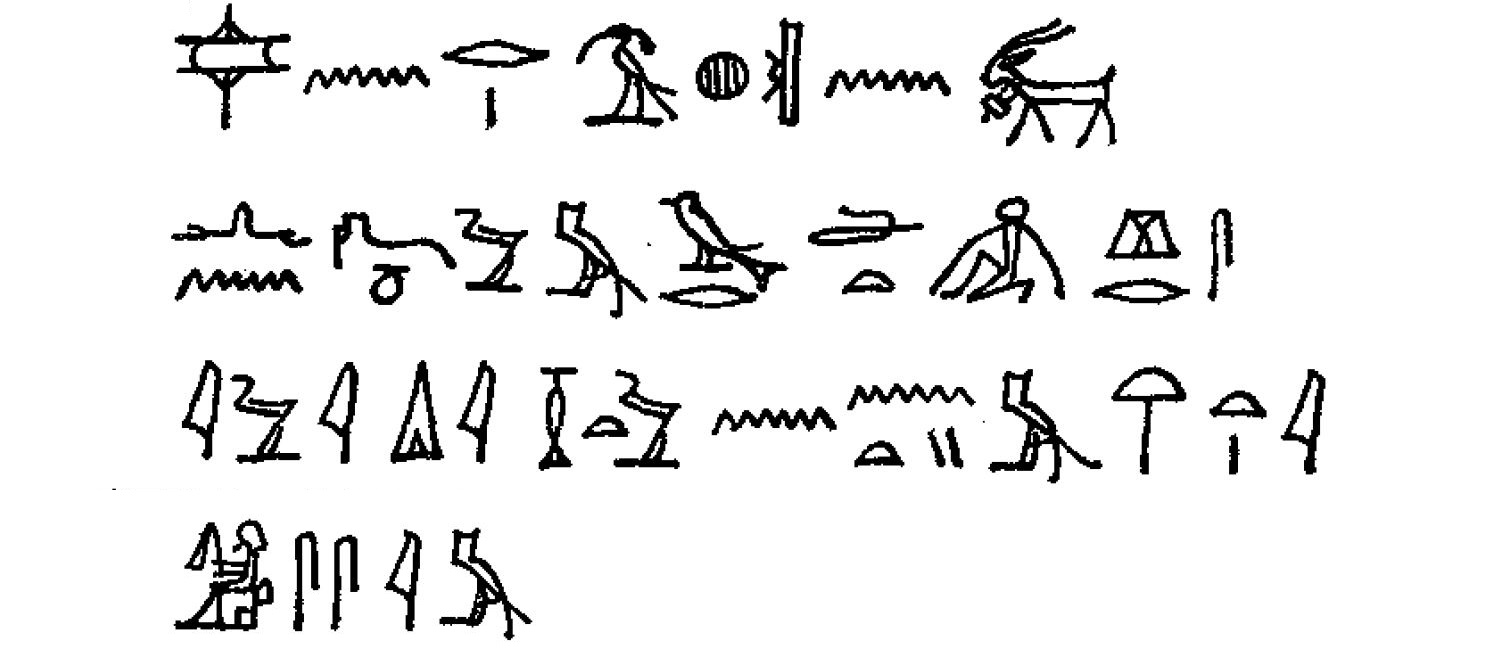

In [87]:
# Wahl eines Beispiels aus dem Ordner Datensatz_Gesamtprozess aus Github oder eines lokal gespeicherten Bildes
ordner_pfad = "https://github.com/davimon23/MAHieroglyphenOCR/raw/main/data/Datensatz_Gesamtprozess"
bild_datei = "SetheIV_S1032unten.jpg"

bild_pfad = os.path.join(ordner_pfad, bild_datei)
# bild_pfad = "..."     # lokales Beispiel

# Lade das Bild mit OpenCV
response = requests.get(bild_pfad, stream=True).raw
img_geladen = np.asarray(bytearray(response.read()), dtype="uint8")
img_geladen = cv2.imdecode(img_geladen, cv2.IMREAD_COLOR)

# Zeige das Bild an
cv2_imshow(img_geladen)

# Durchlauf des Gesamtprozesses in Einzelschritten

(für ein genaueres Tracking der Zwischenergebnisse)



## Segmentierung


Darstellung des Ergebnisses der Segmentierung als Bounding Boxen mit Konfidenz

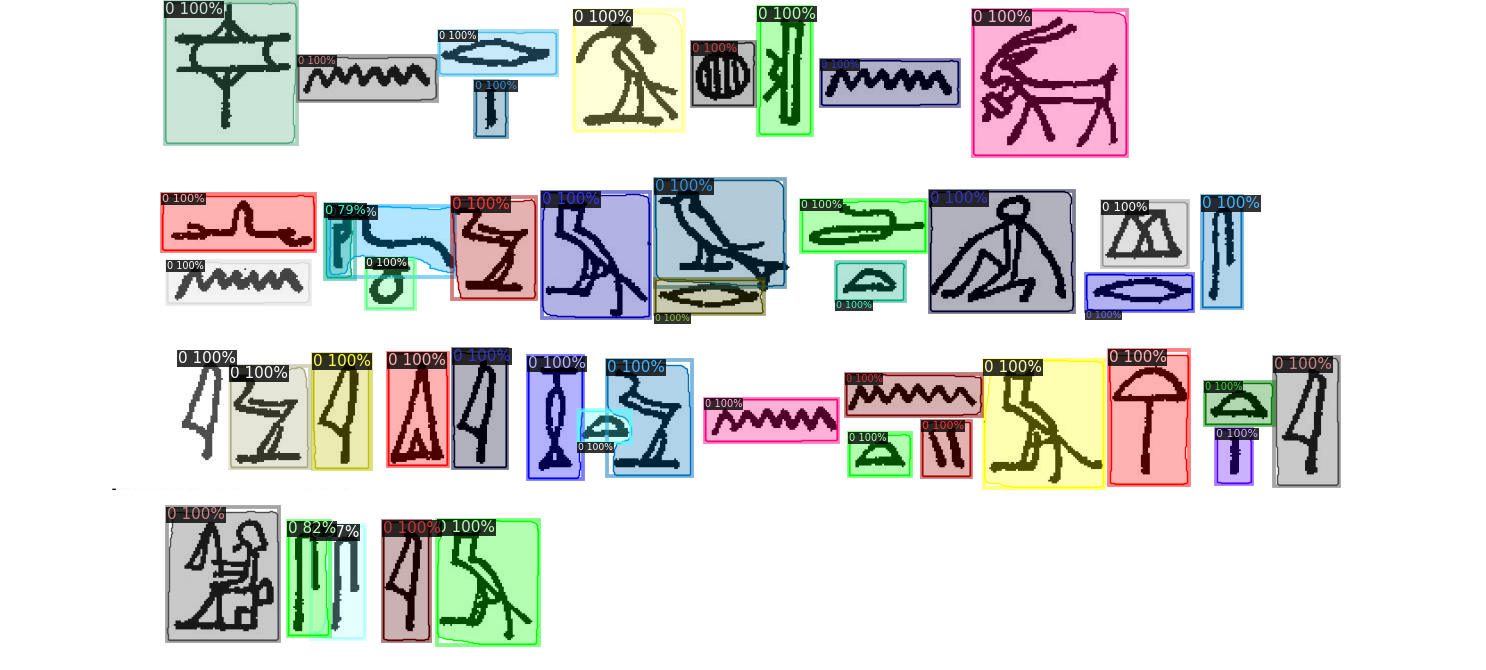

In [88]:
from detectron2.utils.visualizer import ColorMode

# Modellanwendung
outputs = predictor(img_geladen)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

# Visualisierung der Ergebnisse
v = Visualizer(img_geladen[:, :, ::-1],
                scale=1,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Speichern der BBs in einer Liste
bboxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()

## Links-Rechts-Leserichtung

In [89]:
# Durchführung der Inferenz mit dem YOLO-Modell
results = model.predict(img_geladen)

# Extraktion der vorhergesagten Klasse
predicted_class_index = results[0].probs.top1  # Index der wahrscheinlichsten Klasse

# Label der wahrscheinlichsten Klasse
direction = model.names[predicted_class_index]  # Label aus dem model.names-Dictionary

# Ausgabe des Labels der wahrscheinlichsten Klasse
print("")
print("Vorhergesagte Links-Rechts-Leserichtung: ",direction)


Vorhergesagte Links-Rechts-Leserichtung:  LR


In [90]:
# User fragen, ob der Wert okay ist
user_input = input(f"Ist die Links-Rechts-Leserichtung {direction} korrekt? (Y/N): ")

# Wert ändern, wenn der User N eingibt
if user_input.upper() == "N":
    if direction == "RL":
        direction = "LR"
    else:
        direction = "RL"
print("Links-Rechts-Leserichtung: ", direction)

Ist die Links-Rechts-Leserichtung LR korrekt? (Y/N): y
Links-Rechts-Leserichtung:  LR


## Bestimmung der Trennlinien und der Ausrichtung

Funktionen check_collision und find_longest_lines

In [91]:
# @title
def check_collision(line, bboxes):
    """
    Überprüft, ob eine Linie eine Bounding Box schneidet.

    Args:
        line: Ein Tuple, das die Start- und Endpunkte der Linie enthält ((x1, y1), (x2, y2)).
        bboxes: Ein NumPy-Array mit den Bounding Boxen im Format [x1, y1, x2, y2].

    Returns:
        True, wenn die Linie eine Bounding Box schneidet, andernfalls False.
    """

    # Cohen-Sutherland-Algorithmus
    def outcode(x, y, xmin, ymin, xmax, ymax):
        code = 0
        if y > ymax:
            code |= 8  # Bottom
        elif y < ymin:
            code |= 4  # Top
        if x > xmax:
            code |= 2  # Right
        elif x < xmin:
            code |= 1  # Left
        return code

    x1, y1 = line[0]
    x2, y2 = line[1]

    for bbox in bboxes:
      xmin, ymin, xmax, ymax = bbox
      # Box auf 85% reduzieren
      center_x = (xmin + xmax) / 2
      center_y = (ymin + ymax) / 2
      width = xmax - xmin
      height = ymax - ymin
      xmin = center_x - (width * 0.85) / 2
      ymin = center_y - (height * 0.85) / 2
      xmax = center_x + (width * 0.85) / 2
      ymax = center_y + (height * 0.85) / 2

      code1 = outcode(x1, y1, xmin, ymin, xmax, ymax)
      code2 = outcode(x2, y2, xmin, ymin, xmax, ymax)

      while True:
          if code1 == 0 and code2 == 0:  # Beide Punkte innerhalb der Box
              return True  # Kollision erkannt
          elif code1 & code2 != 0:  # Beide Punkte außerhalb der Box und auf der gleichen Seite
                break  # Keine Kollision mit der aktuellen Box -> weiter zur nächsten Box
          else:  # Linie schneidet die Box potenziell
              code = code1 if code1 != 0 else code2

              # Schnittpunkt berechnen
              if code & 4:  # Top
                  x = x1 + (x2 - x1) * (ymin - y1) / (y2 - y1)
                  y = ymin
              elif code & 8:  # Bottom
                  x = x1 + (x2 - x1) * (ymax - y1) / (y2 - y1)
                  y = ymax
              elif code & 2:  # Right
                  y = y1 + (y2 - y1) * (xmax - x1) / (x2 - x1)
                  x = xmax
              elif code & 1:  # Left
                  y = y1 + (y2 - y1) * (xmin - x1) / (x2 - x1)
                  x = xmin

              if code == code1:
                  x1, y1 = x, y
                  code1 = outcode(x1, y1, xmin, ymin, xmax, ymax)
              else:
                  x2, y2 = x, y
                  code2 = outcode(x2, y2, xmin, ymin, xmax, ymax)

              # Überprüfung auf Kollision nach Aktualisierung der Endpunkte
              if code1 == 0 or code2 == 0:
                  return True # Kollision erkannt, da ein Endpunkt innerhalb der Box liegt.

    return False  # Keine Kollision mit einer Box


def find_longest_lines(bboxes, image_width, image_height):
    """
    Findet die längsten Linien im Bild, die keine BB schneiden und damit das Bild in Zeilen/Spalten zerlegen.

    Args:
        image_width, image_height: Breite/Höhe des Bildes.
        bboxes: Ein NumPy-Array mit den Bounding Boxen im Format [x1, y1, x2, y2].

    Returns:
        Liste der Trennlinien.
    """

    horizontal_lines = []
    vertical_lines = []

    # Waagerechte Linien
    for y in range(image_height):
        line = ((0, y), (image_width - 1, y))  # Linie über die gesamte Bildbreite
        if not check_collision(line, bboxes):
            horizontal_lines.append(line)

    # Senkrechte Linien
    for x in range(image_width):
        line = ((x, 0), (x, image_height - 1))  # Linie über die gesamte Bildhöhe
        if not check_collision(line, bboxes):
            vertical_lines.append(line)

    # Korrektur der Listen: Entferne alle Linienbündel am Rand
    # vertical_lines
    x = 0
    while x < image_width:
        found_line = False
        for i, line in enumerate(vertical_lines):
            if line[0][0] == x:
                vertical_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        x += 1

    x = image_width - 1
    while x >= 0:
        found_line = False
        for i, line in enumerate(vertical_lines):
            if line[0][0] == x:
                vertical_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        x -= 1

    # horizontal_lines
    y = 0
    while y < image_height:
        found_line = False
        for i, line in enumerate(horizontal_lines):
            if line[0][1] == y:
                horizontal_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        y += 1

    y = image_height - 1
    while y >= 0:
        found_line = False
        for i, line in enumerate(horizontal_lines):
            if line[0][1] == y:
                horizontal_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        y -= 1

    # Längste Seitenkante bestimmen
    longest_side = 0
    for bbox in bboxes:
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        longest_side = max(longest_side, width, height)

    # Linien filtern
    horizontal_lines = [line for line in horizontal_lines if line[1][0] - line[0][0] >= 2 * longest_side]  # Filter horizontal lines
    vertical_lines = [line for line in vertical_lines if line[1][1] - line[0][1] >= 2 * longest_side]  # Filter vertical lines


    # Längere Linien auswählen
    if image_width > image_height and horizontal_lines:  # Waagerechte Linien sind länger
        return horizontal_lines
    elif image_height > image_width and vertical_lines:  # Senkrechte Linien sind länger
        return vertical_lines
    elif horizontal_lines and vertical_lines:
      return horizontal_lines + vertical_lines # Beide gleich lang
    elif horizontal_lines:
      return horizontal_lines # Senkrechte Linien leer
    elif vertical_lines:
      return vertical_lines # Waagerechte Linien leer
    else:
        return []  # Keine Linien gefunden

Liste der auf 85% reduzierten Boxen

In [92]:
bboxes_reduced = []

for bbox in bboxes:
      xmin, ymin, xmax, ymax = bbox
      # Box auf 85% reduzieren
      center_x = (xmin + xmax) / 2
      center_y = (ymin + ymax) / 2
      width = xmax - xmin
      height = ymax - ymin
      xmin = center_x - (width * 0.85) / 2
      ymin = center_y - (height * 0.85) / 2
      xmax = center_x + (width * 0.85) / 2
      ymax = center_y + (height * 0.85) / 2

      # reduzierte Bounding Box zur Liste hinzufügen
      bboxes_reduced.append([xmin, ymin, xmax, ymax])

In [30]:
print(img_geladen.shape[1], img_geladen.shape[0])

1486 670


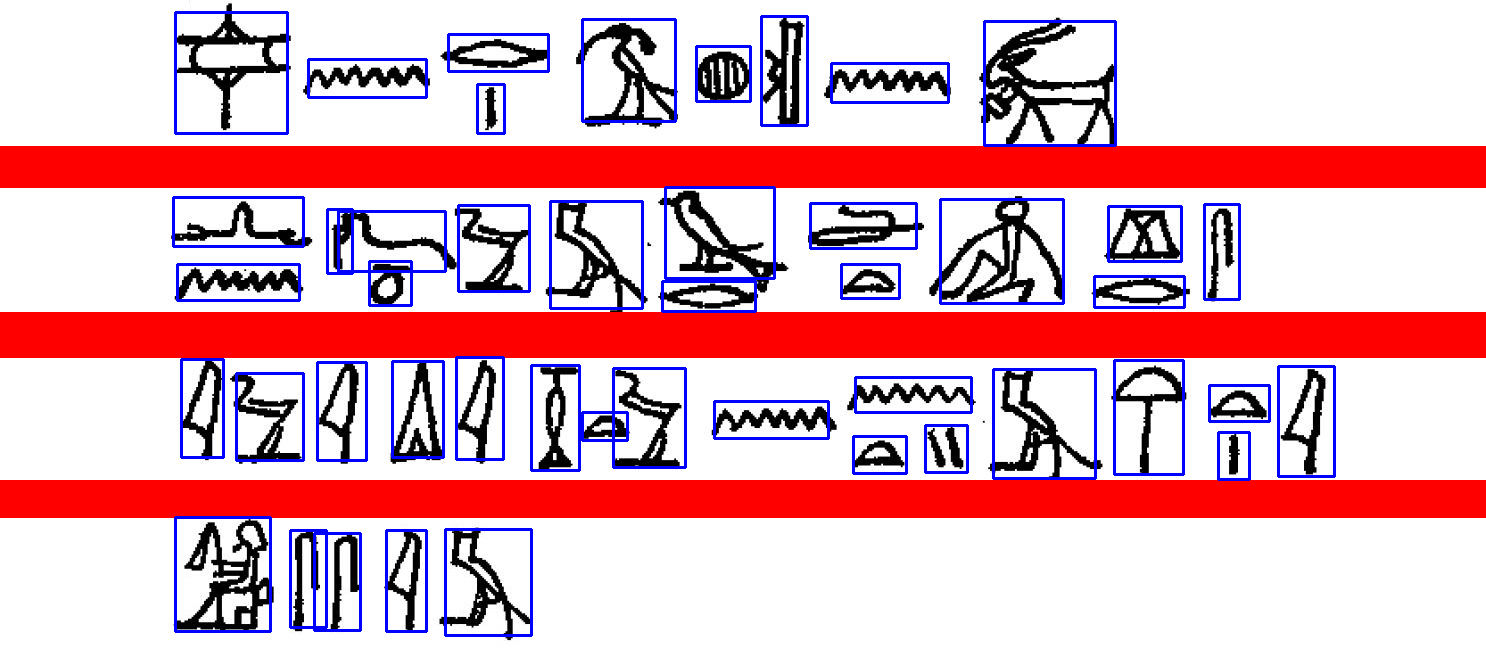

In [93]:
# Aufruf
longest_lines = find_longest_lines(bboxes, img_geladen.shape[1], img_geladen.shape[0])

# Speichere eine Kopie des Originals
img = img_geladen.copy()

for line in longest_lines:
    #print(line)
    cv2.line(img, line[0], line[1], (0, 0, 255), 1)

# bboxes_reduced auf dem Bild ausgeben
for bbox in bboxes_reduced:
    x1, y1, x2, y2 = map(int, bbox)  # Koordinaten in Integer umwandeln
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blaue Bounding Boxes

cv2_imshow(img)
#print(longest_lines)

Funktion center_lines


In [94]:
# @title
def center_lines(lines):
    """
    Zentriert Linien, die direkt nebeneinander liegen.

    Args:
        lines: Eine Liste von Linien (Tuples von Start- und Endpunkten).

    Returns:
        Eine Liste von zentrierten Linien.
    """

    horizontal_lines = []
    vertical_lines = []

    # Linien in horizontal und vertikal unterteilen
    for line in lines:
      if line[0][0] == line[1][0]:
        vertical_lines.append(line)
      else:
        horizontal_lines.append(line)

    centered_lines = []

    # Horizontale Linien zentrieren
    if horizontal_lines:
        horizontal_lines.sort(key=lambda line: line[0][1])  # nach y-Koordinate sortieren

        grouped_lines = []
        current_group = [horizontal_lines[0]]
        for i in range(1, len(horizontal_lines)):
            if horizontal_lines[i][0][1] == horizontal_lines[i - 1][0][1] + 1: # sind direkt nebeneinander
                current_group.append(horizontal_lines[i])
            else:
                grouped_lines.append(current_group)
                current_group = [horizontal_lines[i]]

        grouped_lines.append(current_group) # füge letzte Gruppe hinzu

        for group in grouped_lines:
           ys = [line[0][1] for line in group]
           avg_y = int(sum(ys) / len(ys))
           centered_line = ((group[0][0][0], avg_y), (group[0][1][0], avg_y))
           centered_lines.append(centered_line)

    # Vertikale Linien zentrieren
    if vertical_lines:
      vertical_lines.sort(key=lambda line: line[0][0])  # nach x-Koordinate sortieren
      grouped_lines = []
      current_group = [vertical_lines[0]]
      for i in range(1, len(vertical_lines)):
            if vertical_lines[i][0][0] == vertical_lines[i - 1][0][0] + 1: # sind direkt nebeneinander
                current_group.append(vertical_lines[i])
            else:
                grouped_lines.append(current_group)
                current_group = [vertical_lines[i]]

      grouped_lines.append(current_group) # füge letzte Gruppe hinzu

      for group in grouped_lines:
        xs = [line[0][0] for line in group]
        avg_x = int(sum(xs) / len(xs))
        centered_line = ((avg_x, group[0][0][1]), (avg_x, group[0][1][1]))
        centered_lines.append(centered_line)

    return centered_lines

In [95]:
# Aufruf
centered_lines = center_lines(longest_lines)

#print(centered_lines)

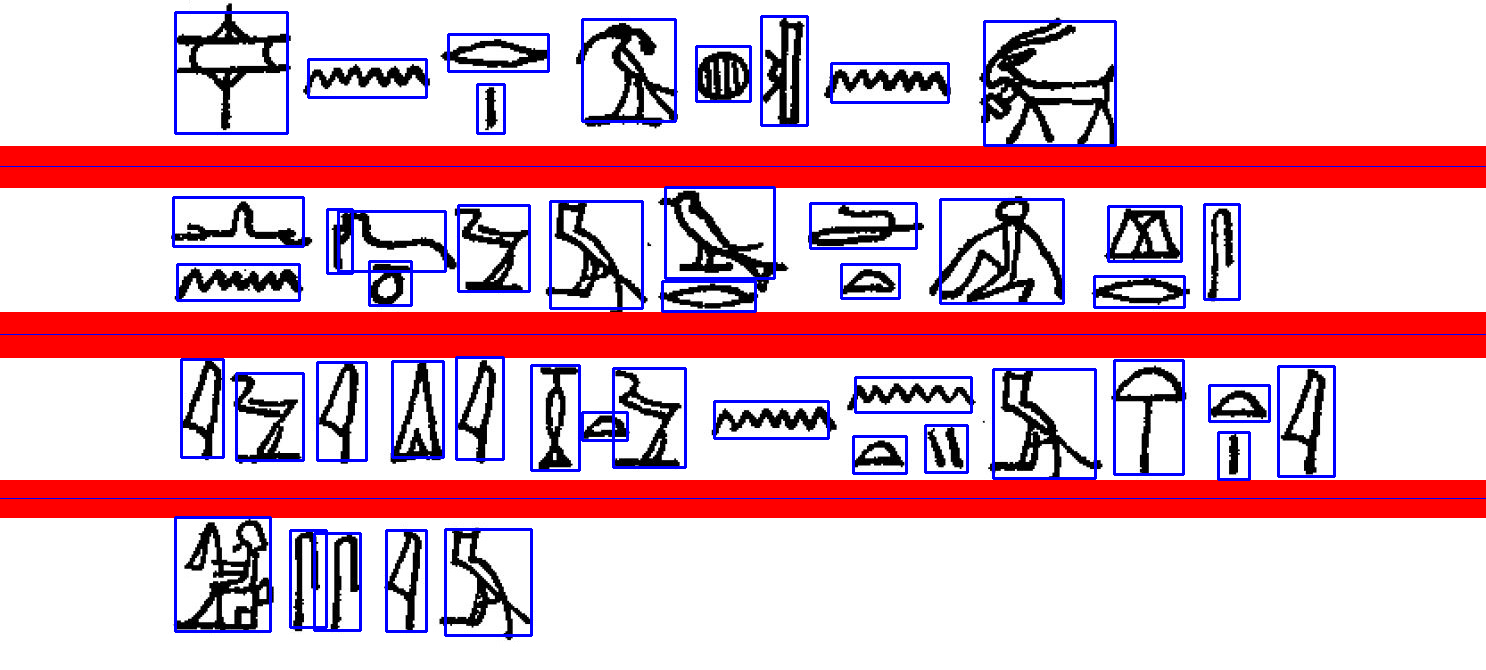

In [96]:
# Linien auf das Bild zeichnen (mit blauer Farbe)
for line in centered_lines:
    cv2.line(img, line[0], line[1], (255, 0, 0), 1) # Farbe auf Blau gesetzt

# Bild anzeigen
cv2_imshow(img)

Funktion determine_arrangement

In [36]:
# @title
import numpy as np

def determine_arrangement(centered_lines, bboxes):
    """
    Bestimmt die Anordnung des Texts (Zeilen oder Spalten) anhand der
    zentrierten Linien oder der Bounding Boxes.

    Args:
        centered_lines: Eine Liste von zentrierten Linien.
        bboxes: Eine Liste von Bounding Boxes.

    Returns:
        Ein Tuple: (arrangement, x_midpoints, y_midpoints).
    """

    x_midpoints = []
    y_midpoints = []

    if not centered_lines:
      x_min = float('inf')
      x_max = float('-inf')
      y_min = float('inf')
      y_max = float('-inf')

      for bbox in bboxes:
        x_min = min(x_min, bbox[0])
        y_min = min(y_min, bbox[1])
        x_max = max(x_max, bbox[2])
        y_max = max(y_max, bbox[3])

      if x_max - x_min > y_max - y_min:
            arrangement = "Zeilen"
      else:
            arrangement = "Spalten"
      return arrangement, x_midpoints, y_midpoints

    else:
      # Kopie der Liste erstellen
      new_centered_lines = centered_lines[:]

      first_line = new_centered_lines[0]
      if first_line[0][0] == first_line[1][0]: # Vertikal
          arrangement = "Spalten"
          x_midpoints = [line[0][0] for line in new_centered_lines]
      else: # Horizontal
        arrangement = "Zeilen"
        y_midpoints = [line[0][1] for line in new_centered_lines]

    return arrangement, x_midpoints, y_midpoints

In [97]:
# Aufruf
arrangement, x_midpoints, y_midpoints = determine_arrangement(centered_lines, bboxes)

print("Arrangement:", arrangement)
print("x_midpoints:", x_midpoints)
print("y_midpoints:", y_midpoints)

Arrangement: Zeilen
x_midpoints: []
y_midpoints: [166, 334, 498]


## Sequenzierung der Boxen

Funktion split_bounding_boxes

In [98]:
# @title
def split_bounding_boxes(bboxes, arrangement, direction, x_midpoints, y_midpoints):
  """
  Teilt die Bounding Boxen in Teilisten auf, basierend auf den x_midpoints oder y_midpoints.

  Args:
    bboxes: Die Bounding Boxen.
    arrangement: Die Anordnung des Texts ("Spalten" oder "Zeilen").
    direction: Die Leserichtung ("LR" oder "RL").
    x_midpoints: Die Mittelpunkte der weißen Bereiche auf der x-Achse.
    y_midpoints: Die Mittelpunkte der weißen Bereiche auf der y-Achse.

  Returns:
    Eine Liste von Teilisten, die jeweils Bounding Boxen enthalten.
  """

  if x_midpoints == [] and y_midpoints == []:  # Es liegt nur eine Zeile oder nur eine Spalte vor
      sublists = [[np.array(row, dtype=np.float32) for row in bboxes]]
  else:
    if arrangement == "Spalten":
      if direction == "RL":
        # Sortiere x_midpoints in absteigender Reihenfolge
        x_midpoints.sort(reverse=True)

      else:  # direction == "LR"
        # Sortiere x_midpoints in aufsteigender Reihenfolge
        x_midpoints.sort()

      # Erstelle Teilisten basierend auf x_midpoints
      sublists = [[] for _ in range(len(x_midpoints) + 1)]
      for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        center_x = (x1 + x2) / 2

        # Finde die richtige Teilliste für die Bounding Box
        list_index = 0
        for i, midpoint in enumerate(x_midpoints):
          if direction == "RL" and center_x > midpoint:
            list_index = i
            break
          else:
            list_index = len(x_midpoints)

          if direction == "LR" and center_x < midpoint:
            list_index = i
            break
          else:
            list_index = len(x_midpoints)

        #print(list_index)
        sublists[list_index].append(bbox)

    elif arrangement == "Zeilen":
      # Sortiere y_midpoints in aufsteigender Reihenfolge
      y_midpoints.sort()

      # Erstelle Teilisten basierend auf y_midpoints
      sublists = [[] for _ in range(len(y_midpoints) + 1)]
      for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        center_y = (y1 + y2) / 2

        # Finde die richtige Teilliste für die Bounding Box
        list_index = 0
        for i, midpoint in enumerate(y_midpoints):
          if center_y < midpoint:
            list_index = i
            break
          else:
            list_index = len(y_midpoints)

        #print(list_index)
        sublists[list_index].append(bbox)

  return sublists

Teilliste 1:


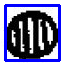

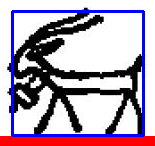

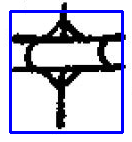

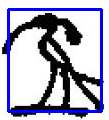

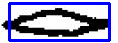

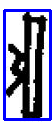

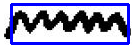

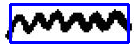

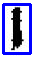

Teilliste 2:


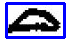

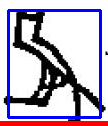

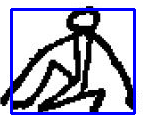

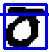

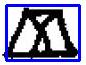

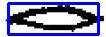

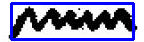

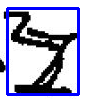

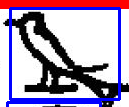

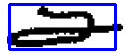

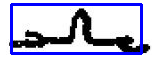

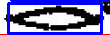

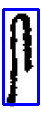

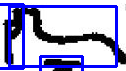

Teilliste 3:


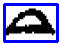

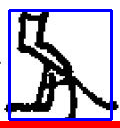

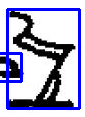

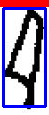

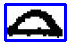

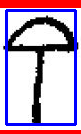

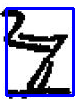

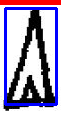

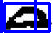

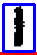

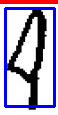

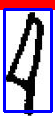

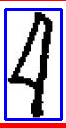

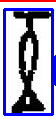

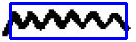

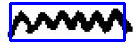

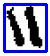

Teilliste 4:


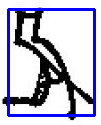

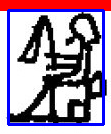

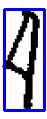

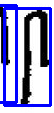

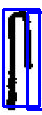

In [99]:
# Aufteilen der Bounding Boxen in Teilisten
sublists_bboxes = split_bounding_boxes(bboxes, arrangement, direction, x_midpoints, y_midpoints)

# Extrahieren der Bildausschnitte für jede Teilliste
sublists_images = []
for sublist_bboxes in sublists_bboxes:
    image_crops = []  # Liste der Bildausschnitte für die aktuelle Teilliste
    for bbox in sublist_bboxes:
      #print(bbox)
      x1, y1, x2, y2 = bbox.astype(int)
      #print(x1, y1, x2, y2)
      image_crop = img[y1:y2, x1:x2]
      image_crops.append(image_crop)
    sublists_images.append(image_crops)  # Füge die Liste der Bildausschnitte für die aktuelle Teilliste hinzu

# Ausgeben der Teillisten als Bildausschnitte
for i, sublist_images in enumerate(sublists_images):
  print(f"Teilliste {i + 1}:")
  for j, image_crop in enumerate(sublist_images):
     # Zeige den Bildausschnitt an
     cv2_imshow(image_crop)

Funktion sort_bboxes_and_extract_images

In [100]:
# @title
def sort_bboxes_and_extract_images(sublists_bboxes, img, arrangement, direction):
    """
    Sortiert die Bounding Boxes innerhalb jeder Teilliste und extrahiert die Bildausschnitte.

    Args:
        sublists_bboxes: Liste von Teillisten mit Bounding Boxes.
        img: Das Originalbild.
        arrangement: Die Anordnung des Texts ("Spalten" oder "Zeilen").
        direction: Die Leserichtung ("LR" oder "RL").

    Returns:
        Eine Liste mit den sortierten Bildausschnitten.
    """

    all_image_crops_and_bboxes = []  # Liste für alle sortierten Bildausschnitte und Bounding Boxes

    for sublist_bboxes in sublists_bboxes:
        if arrangement == "Spalten":
            if direction == "RL":
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: (bbox[0] + bbox[2]) / 2 + 2 * (y_max - (bbox[1] + bbox[3]) / 2), reverse=True)  # Sortiere nach x + 2*y absteigend, y-Koordinate wegen Spaltenanordnung doppelt gewichtet, y-Achse invertiert

            else:  # direction == "LR"
                x_max = img.shape[1]
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: ((x_max - bbox[0]) + (x_max - bbox[2]))/2 + 2 * (y_max - (bbox[1] + bbox[3])), reverse=True)  # Sortiere nach x + 2*y absteigend, zusätzlich x-Achse invertiert

        elif arrangement == "Zeilen":
            if direction == "RL":
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: (bbox[0] + bbox[2]) + 0.8 * (y_max - (bbox[1] + bbox[3])), reverse=True)  # Sortiere nach 2*x + y absteigend, x-Koordinate wegen Zeilenanordnung etwas mehr als doppelt gewichtet, y-Achse invertiert.
            else:  # direction == "LR"
                x_max = img.shape[1]
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: ((x_max - bbox[0]) + (x_max - bbox[2])) + 0.8 * (y_max - (bbox[1] + bbox[3])), reverse=True)  # Sortiere nach 2*x + y absteigend, zusätzlich x-Achse invertiert


        # Extrahiere die Bildausschnitte und Bounding Boxes für die sortierten Bounding Boxes
        image_crops_and_bboxes = []
        for bbox in sublist_bboxes:
            x1, y1, x2, y2 = bbox.astype(int)
            image_crop = img[y1:y2, x1:x2]
            image_crops_and_bboxes.append((image_crop, bbox))  # Speichere Bildausschnitt und Bounding Box in einem Tuple
        all_image_crops_and_bboxes.extend(image_crops_and_bboxes)  # Füge die Tupel zur Gesamtliste hinzu

    return all_image_crops_and_bboxes  # Gib die Liste mit Tupeln zurück

Plot des Ergebnisses der Sequenzierung mit der Funktion display_image_crops_horizontally_matplotlib

In [101]:
# @title
def display_image_crops_horizontally_matplotlib(all_image_crops, sublists_bboxes, arrangement, direction, max_edge_length=100):
    """
    Zeigt die Bildausschnitte horizontal und nach Teilliste angeordnet mit Matplotlib an.

    Args:
        all_image_crops: Eine Liste aller Bildausschnitte.
        sublists_bboxes: Eine Liste von Teillisten mit Bounding Boxes.
        arrangement: Die Anordnung des Texts ("Spalten" oder "Zeilen").
        direction: Die Leserichtung ("LR" oder "RL").
        max_edge_length: Die maximale Kantenlänge der skalierten Bildausschnitte.
    """

    current_index = 0  # Index für die aktuelle Position in all_image_crops
    sublist_number = 1  # Nummer der aktuellen Teilliste

    # Bestimme die maximale Breite und Höhe aller Bildausschnitte
    max_width = max(image_crop[0].shape[1] for image_crop in all_image_crops)
    max_height = max(image_crop[0].shape[0] for image_crop in all_image_crops)


    for sublist_bboxes in sublists_bboxes:
        print(f"Teilliste {sublist_number}")

        num_crops = len(sublist_bboxes)

        # Figure und Subplots erstellen, Höhe auf 3 Zoll festlegen
        fig, axes = plt.subplots(1, num_crops, figsize=(num_crops * 1, 1))  # Höhe auf 3 Zoll festgelegt

        # Falls nur ein Bildausschnitt in der Teilliste vorhanden ist, axes als Liste behandeln
        if num_crops == 1:
            axes = [axes]

        # Bildausschnitte in Subplots anzeigen
        for i in range(num_crops):
            image_crop = all_image_crops[current_index][0]
            current_index += 1

            # Bildausschnitt auf die maximale Größe skalieren und mit einem blauen Rahmen versehen
            resized_image = cv2.resize(image_crop, (max_width, max_height))

            # Bildausschnitt skalieren
            height, width = image_crop.shape[:2]
            scale_factor = min(max_edge_length / width, max_edge_length / height)
            resized_image = cv2.resize(image_crop, (int(width * scale_factor), int(height * scale_factor)))

            # Blauer Rahmen nach dem letzten Skalierungsschritt
            height, width = resized_image.shape[:2] # Höhe und Breite des skalierten Bildes
            cv2.rectangle(resized_image, (0, 0), (width - 1, height - 1), (255, 0, 0), 2)  # Blauer Rahmen

            # Bildausschnitt im Subplot anzeigen
            axes[i].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Konvertierung zu RGB für Matplotlib
            axes[i].axis('off')  # Achsen ausblenden

        sublist_number += 1  # Nummer der Teilliste erhöhen

        # Figure anzeigen
        plt.show()

Teilliste 1


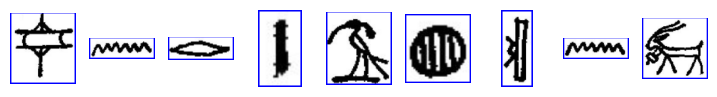

Teilliste 2


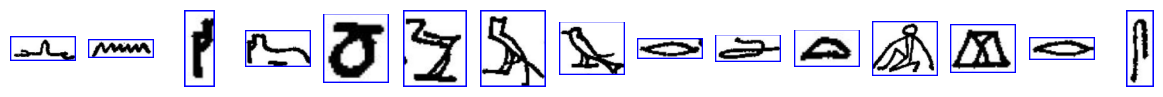

Teilliste 3


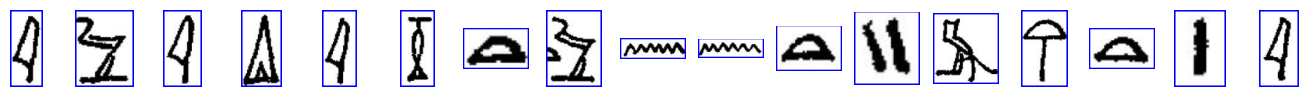

Teilliste 4


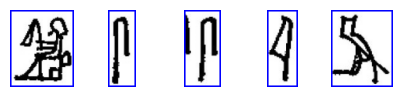

In [102]:
# Speichere eine Kopie des Originals
img_orig = img_geladen.copy()

# Aufteilen der Bounding Boxen in Teilisten
sublists_bboxes = split_bounding_boxes(bboxes, arrangement, direction, x_midpoints, y_midpoints)

# Sortieren der Bounding Boxes und Extrahieren der Bildausschnitte und Bounding Boxes
all_image_crops_and_bboxes = sort_bboxes_and_extract_images(sublists_bboxes, img_orig, arrangement, direction)

# Plot
display_image_crops_horizontally_matplotlib(all_image_crops_and_bboxes, sublists_bboxes, arrangement, direction, max_edge_length=100)

## Klassifikation der Patches


0: 224x224 P5 0.72, P4 0.28, N31 0.00, E8a 0.00, W14 0.00, 151.0ms
Speed: 5.0ms preprocess, 151.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


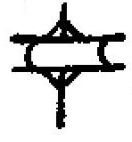


0: 224x224 I14 0.95, N35 0.05, M33 0.00, Z9 0.00, E17 0.00, 116.6ms
Speed: 5.8ms preprocess, 116.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


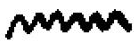


0: 224x224 D21 1.00, O29 0.00, D4 0.00, V13 0.00, V26 0.00, 114.6ms
Speed: 5.4ms preprocess, 114.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


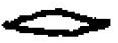


0: 224x224 M13 0.55, Z1 0.27, O29a 0.03, S40 0.03, U28 0.02, 120.3ms
Speed: 4.6ms preprocess, 120.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


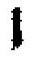


0: 224x224 G25 0.96, G26 0.02, G31 0.01, A59 0.01, G30 0.00, 118.5ms
Speed: 4.0ms preprocess, 118.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


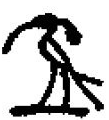


0: 224x224 O48 0.99, Aa1 0.01, O50 0.00, O49 0.00, D25 0.00, 119.8ms
Speed: 3.8ms preprocess, 119.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


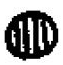


0: 224x224 Y1a 0.80, T18 0.16, Y1 0.04, M18 0.00, M17 0.00, 114.4ms
Speed: 5.3ms preprocess, 114.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


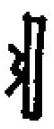


0: 224x224 N35 0.97, I14 0.03, N25 0.00, N33a 0.00, M33 0.00, 133.7ms
Speed: 6.0ms preprocess, 133.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


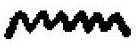


0: 224x224 E31 0.68, E28 0.19, E7 0.06, E10 0.03, N13 0.02, 127.4ms
Speed: 5.5ms preprocess, 127.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


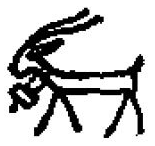


0: 224x224 D35 1.00, N25 0.00, D54 0.00, I14 0.00, A7 0.00, 114.6ms
Speed: 5.4ms preprocess, 114.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


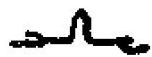


0: 224x224 N35 1.00, I14 0.00, N33a 0.00, N25 0.00, Z9 0.00, 116.3ms
Speed: 7.2ms preprocess, 116.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


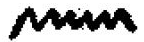


0: 224x224 Z1 0.32, S3 0.28, T20 0.08, M17 0.07, G43 0.05, 118.9ms
Speed: 4.9ms preprocess, 118.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)



0: 224x224 U13 0.66, F13 0.10, U21 0.05, E9a 0.03, F19 0.02, 122.7ms
Speed: 4.6ms preprocess, 122.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


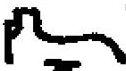


0: 224x224 W24 0.99, W12 0.00, W9 0.00, V6 0.00, V33 0.00, 112.8ms
Speed: 3.7ms preprocess, 112.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


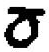


0: 224x224 G43 0.92, U1 0.05, E34 0.02, U17 0.00, G1 0.00, 130.9ms
Speed: 5.1ms preprocess, 130.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


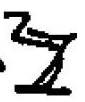


0: 224x224 G17 1.00, G1 0.00, G26 0.00, G5 0.00, G20 0.00, 131.8ms
Speed: 4.9ms preprocess, 131.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


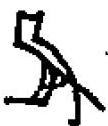


0: 224x224 G36 0.65, G37 0.15, G36a 0.11, G35 0.07, G1 0.02, 118.4ms
Speed: 7.9ms preprocess, 118.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


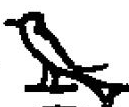


0: 224x224 D21 1.00, D4 0.00, V13 0.00, O29 0.00, N36 0.00, 122.8ms
Speed: 7.1ms preprocess, 122.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


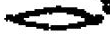


0: 224x224 F46a 0.50, M11 0.27, V13 0.16, F18 0.03, Y5 0.01, 120.1ms
Speed: 7.6ms preprocess, 120.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


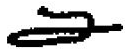


0: 224x224 X1 0.99, D41 0.01, N30 0.00, I9 0.00, E9 0.00, 118.6ms
Speed: 4.8ms preprocess, 118.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


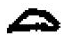


0: 224x224 A7 1.00, A2 0.00, A8 0.00, A14a 0.00, A10 0.00, 118.3ms
Speed: 4.6ms preprocess, 118.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


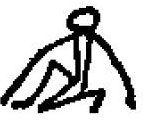


0: 224x224 T28 1.00, W5 0.00, W12 0.00, S23 0.00, W11 0.00, 134.2ms
Speed: 4.2ms preprocess, 134.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


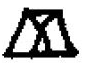


0: 224x224 D21 1.00, Aa16 0.00, O29 0.00, V13 0.00, D25 0.00, 125.8ms
Speed: 11.8ms preprocess, 125.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


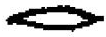


0: 224x224 S29 1.00, M17 0.00, S40 0.00, W1 0.00, A53 0.00, 130.1ms
Speed: 7.7ms preprocess, 130.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


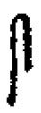


0: 224x224 M18 0.57, M17 0.38, Aa20 0.03, W25 0.01, R11 0.00, 114.6ms
Speed: 5.7ms preprocess, 114.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


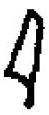


0: 224x224 G43 0.99, U17 0.01, U4 0.00, U1 0.00, G1 0.00, 121.7ms
Speed: 4.6ms preprocess, 121.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


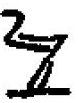


0: 224x224 M17 1.00, H6 0.00, M18 0.00, M1 0.00, Q7 0.00, 125.4ms
Speed: 5.2ms preprocess, 125.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


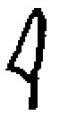


0: 224x224 X8 1.00, M44 0.00, U33 0.00, W25 0.00, Q7 0.00, 120.2ms
Speed: 4.9ms preprocess, 120.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


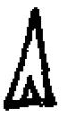


0: 224x224 M17 0.97, M18 0.02, W25 0.00, Aa20 0.00, H6 0.00, 120.1ms
Speed: 5.1ms preprocess, 120.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


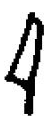


0: 224x224 U36 0.35, S33 0.33, A53 0.18, Aa30 0.05, V18 0.03, 129.9ms
Speed: 10.4ms preprocess, 129.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


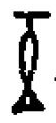


0: 224x224 X1 1.00, D1 0.00, D46 0.00, I9 0.00, D54 0.00, 134.9ms
Speed: 5.9ms preprocess, 134.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


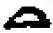


0: 224x224 G43 0.99, U1 0.00, G35 0.00, G25 0.00, E34 0.00, 120.6ms
Speed: 4.3ms preprocess, 120.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


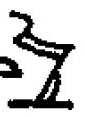


0: 224x224 I14 0.63, N35 0.37, N25 0.00, M33 0.00, Z9 0.00, 122.1ms
Speed: 6.7ms preprocess, 122.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


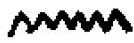


0: 224x224 N35 0.87, I14 0.13, N25 0.00, Z9 0.00, M33 0.00, 123.3ms
Speed: 5.8ms preprocess, 123.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


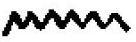


0: 224x224 X1 1.00, I6 0.00, N30 0.00, X2 0.00, T26 0.00, 124.0ms
Speed: 7.0ms preprocess, 124.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


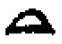


0: 224x224 Z4 1.00, D3 0.00, Z2 0.00, W12 0.00, Z4a 0.00, 121.8ms
Speed: 4.5ms preprocess, 121.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


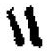


0: 224x224 G17 1.00, G1 0.00, G23 0.00, G20 0.00, G26 0.00, 142.9ms
Speed: 5.0ms preprocess, 142.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


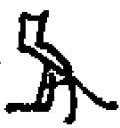


0: 224x224 S36 0.98, U24 0.02, U26 0.00, U25 0.00, O18 0.00, 120.6ms
Speed: 5.4ms preprocess, 120.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


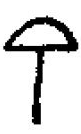


0: 224x224 X1 1.00, D41 0.00, N30 0.00, D54 0.00, D40 0.00, 129.9ms
Speed: 4.4ms preprocess, 129.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


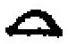


0: 224x224 Z1 0.96, S40 0.02, O36c 0.00, Aa21 0.00, Z3 0.00, 126.1ms
Speed: 4.6ms preprocess, 126.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


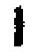


0: 224x224 M17 1.00, H6 0.00, M18 0.00, H6a 0.00, C3 0.00, 123.9ms
Speed: 5.4ms preprocess, 123.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


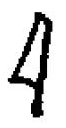


0: 224x224 A51 0.99, B6 0.00, A52 0.00, A11 0.00, A42 0.00, 126.0ms
Speed: 4.4ms preprocess, 126.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


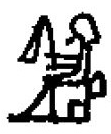


0: 224x224 S29 1.00, S44 0.00, M17 0.00, O4 0.00, M17a 0.00, 120.7ms
Speed: 6.7ms preprocess, 120.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


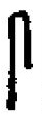


0: 224x224 S29 1.00, S44 0.00, M17a 0.00, Z2a 0.00, O4 0.00, 138.7ms
Speed: 5.3ms preprocess, 138.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


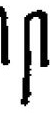


0: 224x224 M17 1.00, M18 0.00, H6 0.00, M1 0.00, F9 0.00, 117.5ms
Speed: 5.5ms preprocess, 117.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


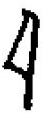


0: 224x224 G17 0.97, G5 0.03, G1 0.00, G21 0.00, A17 0.00, 131.3ms
Speed: 4.2ms preprocess, 131.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


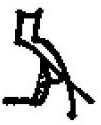


Gardinersequenz: 
P5 I14 D21 M13 G25 O48 Y1a N35 E31 D35 N35 Z1 U13 W24 G43 G17 G36 D21 F46a X1 A7 T28 D21 S29 M18 G43 M17 X8 M17 U36 X1 G43 I14 N35 X1 Z4 G17 S36 X1 Z1 M17 A51 S29 S29 M17 G17


In [104]:
# Liste zum Speichern der vorhergesagten Klassen
predicted_classes = []

# Klassifizierung der gecroppten Bilder
for image_crop in all_image_crops_and_bboxes:
    # Crop in Graustufen umwandeln
    image_crop = cv2.cvtColor(image_crop[0], cv2.COLOR_BGR2GRAY)

    # Inferenz mit dem YOLO-Modell
    results = model2.predict(image_crop, verbose=True)
    cv2_imshow(image_crop)

    # Extraktion der vorhergesagten Klasse
    predicted_class_index = results[0].probs.top1
    predicted_class = model2.names[predicted_class_index]

    # Hinzufügen der vorhergesagten Klasse zur Liste
    predicted_classes.append(predicted_class)

# Ausgabe der Liste
print()
print("Gardinersequenz: ")
# Entferne alle Zeichen, die keine Buchstaben, Zahlen oder Leerzeichen sind
predicted_classes_cleaned = re.sub(r"[^a-zA-Z0-9 ]", "", " ".join(predicted_classes))
print(predicted_classes_cleaned)


# Gesamtprozess in einem Schritt

Benötigte Funktionen (mit Ausgabe der Labels pro Box)

In [85]:
# @title
def check_collision(line, bboxes):
    """
    Überprüft, ob eine Linie eine Bounding Box schneidet.

    Args:
        line: Ein Tuple, das die Start- und Endpunkte der Linie enthält ((x1, y1), (x2, y2)).
        bboxes: Ein NumPy-Array mit den Bounding Boxen im Format [x1, y1, x2, y2].

    Returns:
        True, wenn die Linie eine Bounding Box schneidet, andernfalls False.
    """

    # Cohen-Sutherland-Algorithmus
    def outcode(x, y, xmin, ymin, xmax, ymax):
        code = 0
        if y > ymax:
            code |= 8  # Bottom
        elif y < ymin:
            code |= 4  # Top
        if x > xmax:
            code |= 2  # Right
        elif x < xmin:
            code |= 1  # Left
        return code

    x1, y1 = line[0]
    x2, y2 = line[1]

    for bbox in bboxes:
      xmin, ymin, xmax, ymax = bbox
      # Box auf 85% reduzieren
      center_x = (xmin + xmax) / 2
      center_y = (ymin + ymax) / 2
      width = xmax - xmin
      height = ymax - ymin
      xmin = center_x - (width * 0.85) / 2
      ymin = center_y - (height * 0.85) / 2
      xmax = center_x + (width * 0.85) / 2
      ymax = center_y + (height * 0.85) / 2

      code1 = outcode(x1, y1, xmin, ymin, xmax, ymax)
      code2 = outcode(x2, y2, xmin, ymin, xmax, ymax)

      while True:
          if code1 == 0 and code2 == 0:  # Beide Punkte innerhalb der Box
              return True  # Kollision erkannt
          elif code1 & code2 != 0:  # Beide Punkte außerhalb der Box und auf der gleichen Seite
                break  # Keine Kollision mit der aktuellen Box -> weiter zur nächsten Box
          else:  # Linie schneidet die Box potenziell
              code = code1 if code1 != 0 else code2

              # Schnittpunkt berechnen
              if code & 4:  # Top
                  x = x1 + (x2 - x1) * (ymin - y1) / (y2 - y1)
                  y = ymin
              elif code & 8:  # Bottom
                  x = x1 + (x2 - x1) * (ymax - y1) / (y2 - y1)
                  y = ymax
              elif code & 2:  # Right
                  y = y1 + (y2 - y1) * (xmax - x1) / (x2 - x1)
                  x = xmax
              elif code & 1:  # Left
                  y = y1 + (y2 - y1) * (xmin - x1) / (x2 - x1)
                  x = xmin

              if code == code1:
                  x1, y1 = x, y
                  code1 = outcode(x1, y1, xmin, ymin, xmax, ymax)
              else:
                  x2, y2 = x, y
                  code2 = outcode(x2, y2, xmin, ymin, xmax, ymax)

              # Überprüfung auf Kollision nach Aktualisierung der Endpunkte
              if code1 == 0 or code2 == 0:
                  return True # Kollision erkannt, da ein Endpunkt innerhalb der Box liegt.

    return False  # Keine Kollision mit einer Box


def find_longest_lines(bboxes, image_width, image_height):
    """
    Findet die längsten Linien im Bild, die keine BB schneiden und damit das Bild in Zeilen/Spalten zerlegen.

    Args:
        image_width, image_height: Breite/Höhe des Bildes.
        bboxes: Ein NumPy-Array mit den Bounding Boxen im Format [x1, y1, x2, y2].

    Returns:
        Liste der Trennlinien.
    """

    horizontal_lines = []
    vertical_lines = []

    # Waagerechte Linien
    for y in range(image_height):
        line = ((0, y), (image_width - 1, y))  # Linie über die gesamte Bildbreite
        if not check_collision(line, bboxes):
            horizontal_lines.append(line)

    # Senkrechte Linien
    for x in range(image_width):
        line = ((x, 0), (x, image_height - 1))  # Linie über die gesamte Bildhöhe
        if not check_collision(line, bboxes):
            vertical_lines.append(line)

    # Korrektur der Listen: Entferne alle Linienbündel am Rand
    # vertical_lines
    x = 0
    while x < image_width:
        found_line = False
        for i, line in enumerate(vertical_lines):
            if line[0][0] == x:
                vertical_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        x += 1

    x = image_width - 1
    while x >= 0:
        found_line = False
        for i, line in enumerate(vertical_lines):
            if line[0][0] == x:
                vertical_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        x -= 1

    # horizontal_lines
    y = 0
    while y < image_height:
        found_line = False
        for i, line in enumerate(horizontal_lines):
            if line[0][1] == y:
                horizontal_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        y += 1

    y = image_height - 1
    while y >= 0:
        found_line = False
        for i, line in enumerate(horizontal_lines):
            if line[0][1] == y:
                horizontal_lines.pop(i)
                found_line = True
                break
        if not found_line:
            break
        y -= 1

    # Längste Seitenkante bestimmen
    longest_side = 0
    for bbox in bboxes:
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        longest_side = max(longest_side, width, height)

    # Linien filtern
    horizontal_lines = [line for line in horizontal_lines if line[1][0] - line[0][0] >= 2 * longest_side]  # Filter horizontal lines
    vertical_lines = [line for line in vertical_lines if line[1][1] - line[0][1] >= 2 * longest_side]  # Filter vertical lines


    # Längere Linien auswählen
    if image_width > image_height and horizontal_lines:  # Waagerechte Linien sind länger
        return horizontal_lines
    elif image_height > image_width and vertical_lines:  # Senkrechte Linien sind länger
        return vertical_lines
    elif horizontal_lines and vertical_lines:
      return horizontal_lines + vertical_lines # Beide gleich lang
    elif horizontal_lines:
      return horizontal_lines # Senkrechte Linien leer
    elif vertical_lines:
      return vertical_lines # Waagerechte Linien leer
    else:
        return []  # Keine Linien gefunden


def center_lines(lines):
    """
    Zentriert Linien, die direkt nebeneinander liegen.

    Args:
        lines: Eine Liste von Linien (Tuples von Start- und Endpunkten).

    Returns:
        Eine Liste von zentrierten Linien.
    """

    horizontal_lines = []
    vertical_lines = []

    # Linien in horizontal und vertikal unterteilen
    for line in lines:
      if line[0][0] == line[1][0]:
        vertical_lines.append(line)
      else:
        horizontal_lines.append(line)

    centered_lines = []

    # Horizontale Linien zentrieren
    if horizontal_lines:
        horizontal_lines.sort(key=lambda line: line[0][1])  # nach y-Koordinate sortieren

        grouped_lines = []
        current_group = [horizontal_lines[0]]
        for i in range(1, len(horizontal_lines)):
            if horizontal_lines[i][0][1] == horizontal_lines[i - 1][0][1] + 1: # sind direkt nebeneinander
                current_group.append(horizontal_lines[i])
            else:
                grouped_lines.append(current_group)
                current_group = [horizontal_lines[i]]

        grouped_lines.append(current_group) # füge letzte Gruppe hinzu

        for group in grouped_lines:
           ys = [line[0][1] for line in group]
           avg_y = int(sum(ys) / len(ys))
           centered_line = ((group[0][0][0], avg_y), (group[0][1][0], avg_y))
           centered_lines.append(centered_line)

    # Vertikale Linien zentrieren
    if vertical_lines:
      vertical_lines.sort(key=lambda line: line[0][0])  # nach x-Koordinate sortieren
      grouped_lines = []
      current_group = [vertical_lines[0]]
      for i in range(1, len(vertical_lines)):
            if vertical_lines[i][0][0] == vertical_lines[i - 1][0][0] + 1: # sind direkt nebeneinander
                current_group.append(vertical_lines[i])
            else:
                grouped_lines.append(current_group)
                current_group = [vertical_lines[i]]

      grouped_lines.append(current_group) # füge letzte Gruppe hinzu

      for group in grouped_lines:
        xs = [line[0][0] for line in group]
        avg_x = int(sum(xs) / len(xs))
        centered_line = ((avg_x, group[0][0][1]), (avg_x, group[0][1][1]))
        centered_lines.append(centered_line)

    return centered_lines


def determine_arrangement(centered_lines, bboxes):
    """
    Bestimmt die Anordnung des Texts (Zeilen oder Spalten) anhand der
    zentrierten Linien oder der Bounding Boxes.

    Args:
        centered_lines: Eine Liste von zentrierten Linien.
        bboxes: Eine Liste von Bounding Boxes.

    Returns:
        Ein Tuple: (arrangement, x_midpoints, y_midpoints).
    """

    x_midpoints = []
    y_midpoints = []

    if not centered_lines:
      x_min = float('inf')
      x_max = float('-inf')
      y_min = float('inf')
      y_max = float('-inf')

      for bbox in bboxes:
        x_min = min(x_min, bbox[0])
        y_min = min(y_min, bbox[1])
        x_max = max(x_max, bbox[2])
        y_max = max(y_max, bbox[3])

      if x_max - x_min > y_max - y_min:
            arrangement = "Zeilen"
      else:
            arrangement = "Spalten"
      return arrangement, x_midpoints, y_midpoints

    else:
      # Kopie der Liste erstellen
      new_centered_lines = centered_lines[:]

      first_line = new_centered_lines[0]
      if first_line[0][0] == first_line[1][0]: # Vertikal
          arrangement = "Spalten"
          x_midpoints = [line[0][0] for line in new_centered_lines]
      else: # Horizontal
        arrangement = "Zeilen"
        y_midpoints = [line[0][1] for line in new_centered_lines]

    return arrangement, x_midpoints, y_midpoints


def split_bounding_boxes(bboxes, arrangement, direction, x_midpoints, y_midpoints):
  """
  Teilt die Bounding Boxen in Teilisten auf, basierend auf den x_midpoints oder y_midpoints.

  Args:
    bboxes: Die Bounding Boxen.
    arrangement: Die Anordnung des Texts ("Spalten" oder "Zeilen").
    direction: Die Leserichtung ("LR" oder "RL").
    x_midpoints: Die Mittelpunkte der weißen Bereiche auf der x-Achse.
    y_midpoints: Die Mittelpunkte der weißen Bereiche auf der y-Achse.

  Returns:
    Eine Liste von Teilisten, die jeweils Bounding Boxen enthalten.
  """

  if x_midpoints == [] and y_midpoints == []:  # Es liegt nur eine Zeile oder nur eine Spalte vor
      sublists = [[np.array(row, dtype=np.float32) for row in bboxes]]
  else:
    if arrangement == "Spalten":
      if direction == "RL":
        # Sortiere x_midpoints in absteigender Reihenfolge
        x_midpoints.sort(reverse=True)

      else:  # direction == "LR"
        # Sortiere x_midpoints in aufsteigender Reihenfolge
        x_midpoints.sort()

      # Erstelle Teilisten basierend auf x_midpoints
      sublists = [[] for _ in range(len(x_midpoints) + 1)]
      for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        center_x = (x1 + x2) / 2

        # Finde die richtige Teilliste für die Bounding Box
        list_index = 0
        for i, midpoint in enumerate(x_midpoints):
          if direction == "RL" and center_x > midpoint:
            list_index = i
            break
          else:
            list_index = len(x_midpoints)

          if direction == "LR" and center_x < midpoint:
            list_index = i
            break
          else:
            list_index = len(x_midpoints)

        #print(list_index)
        sublists[list_index].append(bbox)

    elif arrangement == "Zeilen":
      # Sortiere y_midpoints in aufsteigender Reihenfolge
      y_midpoints.sort()

      # Erstelle Teilisten basierend auf y_midpoints
      sublists = [[] for _ in range(len(y_midpoints) + 1)]
      for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        center_y = (y1 + y2) / 2

        # Finde die richtige Teilliste für die Bounding Box
        list_index = 0
        for i, midpoint in enumerate(y_midpoints):
          if center_y < midpoint:
            list_index = i
            break
          else:
            list_index = len(y_midpoints)

        #print(list_index)
        sublists[list_index].append(bbox)

  return sublists


def sort_bboxes_and_extract_images(sublists_bboxes, img, arrangement, direction):
    """
    Sortiert die Bounding Boxes innerhalb jeder Teilliste und extrahiert die Bildausschnitte.

    Args:
        sublists_bboxes: Liste von Teillisten mit Bounding Boxes.
        img: Das Originalbild.
        arrangement: Die Anordnung des Texts ("Spalten" oder "Zeilen").
        direction: Die Leserichtung ("LR" oder "RL").

    Returns:
        Eine Liste mit den sortierten Bildausschnitten.
    """

    all_image_crops_and_bboxes = []  # Liste für alle sortierten Bildausschnitte und Bounding Boxes

    for sublist_bboxes in sublists_bboxes:
        if arrangement == "Spalten":
            if direction == "RL":
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: (bbox[0] + bbox[2]) / 2 + 2 * (y_max - (bbox[1] + bbox[3]) / 2), reverse=True)  # Sortiere nach x + 2*y absteigend, y-Koordinate wegen Spaltenanordnung doppelt gewichtet, y-Achse invertiert

            else:  # direction == "LR"
                x_max = img.shape[1]
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: ((x_max - bbox[0]) + (x_max - bbox[2]))/2 + 2 * (y_max - (bbox[1] + bbox[3])), reverse=True)  # Sortiere nach x + 2*y absteigend, zusätzlich x-Achse invertiert

        elif arrangement == "Zeilen":
            if direction == "RL":
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: (bbox[0] + bbox[2]) + 0.8 * (y_max - (bbox[1] + bbox[3])), reverse=True)  # Sortiere nach 2*x + y absteigend, x-Koordinate wegen Zeilenanordnung etwas mehr als doppelt gewichtet, y-Achse invertiert.
            else:  # direction == "LR"
                x_max = img.shape[1]
                y_max = img.shape[0]
                sublist_bboxes.sort(key=lambda bbox: ((x_max - bbox[0]) + (x_max - bbox[2])) + 0.8 * (y_max - (bbox[1] + bbox[3])), reverse=True)  # Sortiere nach 2*x + y absteigend, zusätzlich x-Achse invertiert


        # Extrahiere die Bildausschnitte und Bounding Boxes für die sortierten Bounding Boxes
        image_crops_and_bboxes = []
        for bbox in sublist_bboxes:
            x1, y1, x2, y2 = bbox.astype(int)
            image_crop = img[y1:y2, x1:x2]
            image_crops_and_bboxes.append((image_crop, bbox))  # Speichere Bildausschnitt und Bounding Box in einem Tuple
        all_image_crops_and_bboxes.extend(image_crops_and_bboxes)  # Füge die Tupel zur Gesamtliste hinzu

    return all_image_crops_and_bboxes  # Gib die Liste mit Tupeln zurück


def display_image_crops_horizontally_matplotlib(all_image_crops, sublists_bboxes, arrangement, direction, max_edge_length=100):
    """
    Zeigt die Bildausschnitte horizontal und nach Teilliste angeordnet mit Matplotlib an.

    Args:
        all_image_crops: Eine Liste aller Bildausschnitte.
        sublists_bboxes: Eine Liste von Teillisten mit Bounding Boxes.
        arrangement: Die Anordnung des Texts ("Spalten" oder "Zeilen").
        direction: Die Leserichtung ("LR" oder "RL").
        max_edge_length: Die maximale Kantenlänge der skalierten Bildausschnitte.
    """

    current_index = 0  # Index für die aktuelle Position in all_image_crops
    sublist_number = 1  # Nummer der aktuellen Teilliste

    # Bestimme die maximale Breite und Höhe aller Bildausschnitte
    max_width = max(image_crop[0].shape[1] for image_crop in all_image_crops)
    max_height = max(image_crop[0].shape[0] for image_crop in all_image_crops)


    for sublist_bboxes in sublists_bboxes:
        print(f"Teilliste {sublist_number}")

        num_crops = len(sublist_bboxes)

        # Figure und Subplots erstellen, Höhe auf 3 Zoll festlegen
        fig, axes = plt.subplots(1, num_crops, figsize=(num_crops * 1, 1))  # Höhe auf 3 Zoll festgelegt

        # Falls nur ein Bildausschnitt in der Teilliste vorhanden ist, axes als Liste behandeln
        if num_crops == 1:
            axes = [axes]

        # Bildausschnitte in Subplots anzeigen
        for i in range(num_crops):
            image_crop = all_image_crops[current_index][0]
            current_index += 1

            # Bildausschnitt auf die maximale Größe skalieren und mit einem blauen Rahmen versehen
            resized_image = cv2.resize(image_crop, (max_width, max_height))

            # Bildausschnitt skalieren
            height, width = image_crop.shape[:2]
            scale_factor = min(max_edge_length / width, max_edge_length / height)
            resized_image = cv2.resize(image_crop, (int(width * scale_factor), int(height * scale_factor)))

            # Blauer Rahmen nach dem letzten Skalierungsschritt
            height, width = resized_image.shape[:2] # Höhe und Breite des skalierten Bildes
            cv2.rectangle(resized_image, (0, 0), (width - 1, height - 1), (255, 0, 0), 2)  # Blauer Rahmen

            # Bildausschnitt im Subplot anzeigen
            axes[i].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Konvertierung zu RGB für Matplotlib
            axes[i].axis('off')  # Achsen ausblenden

        sublist_number += 1  # Nummer der Teilliste erhöhen

        # Figure anzeigen
        plt.show()

**Achtung**: Bei der Ausgabe der Labels pro Box ist die Schriftgröße der Labels nicht dynamisch, sodass die Ausgabe ggf. nicht schön aussieht; ggf. die Schriftgröße und -dicke der beiden Befehle cv2.putText gegen Ende des Codes anpassen.

Originalbild: 


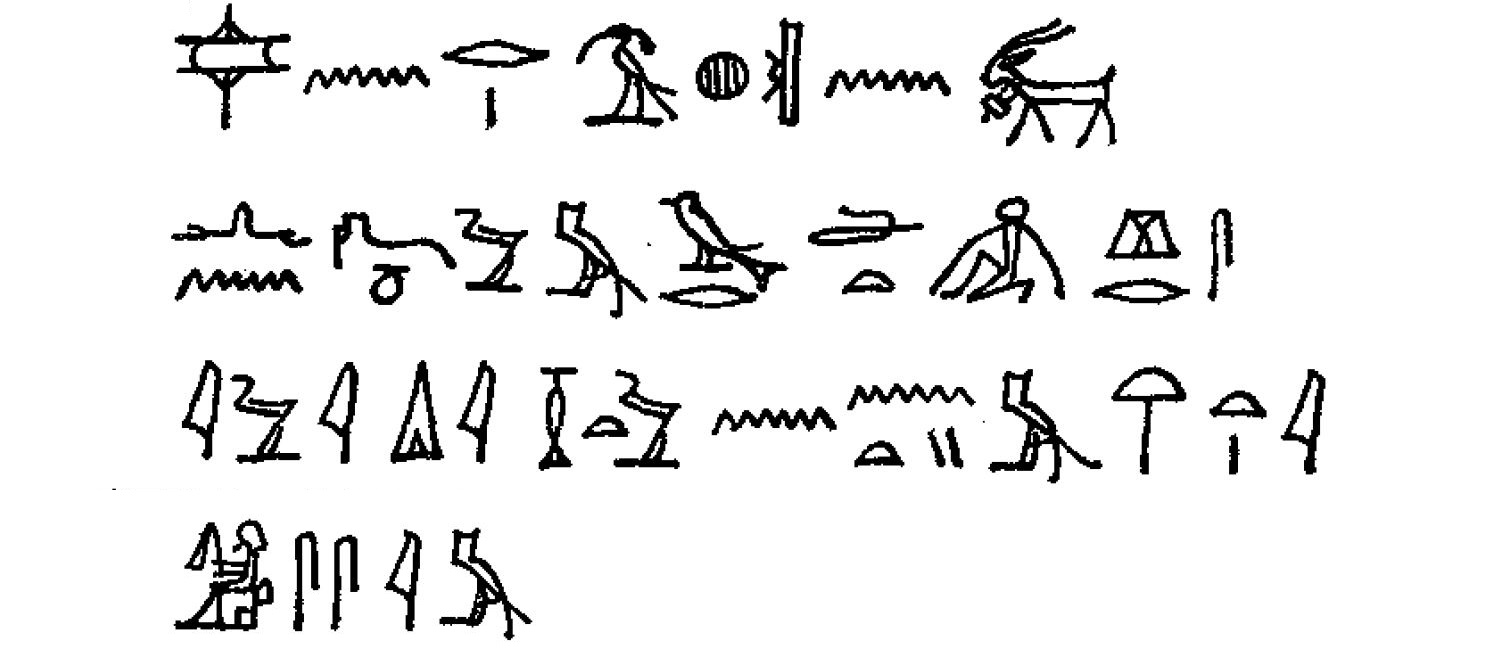


Ist die Links-Rechts-Leserichtung LR korrekt? (Y/N): y
Links-Rechts-Leserichtung:  LR
Arrangement: Zeilen
x_midpoints: []
y_midpoints: [166, 334, 498]

Segmentierung und Trennlinien: 


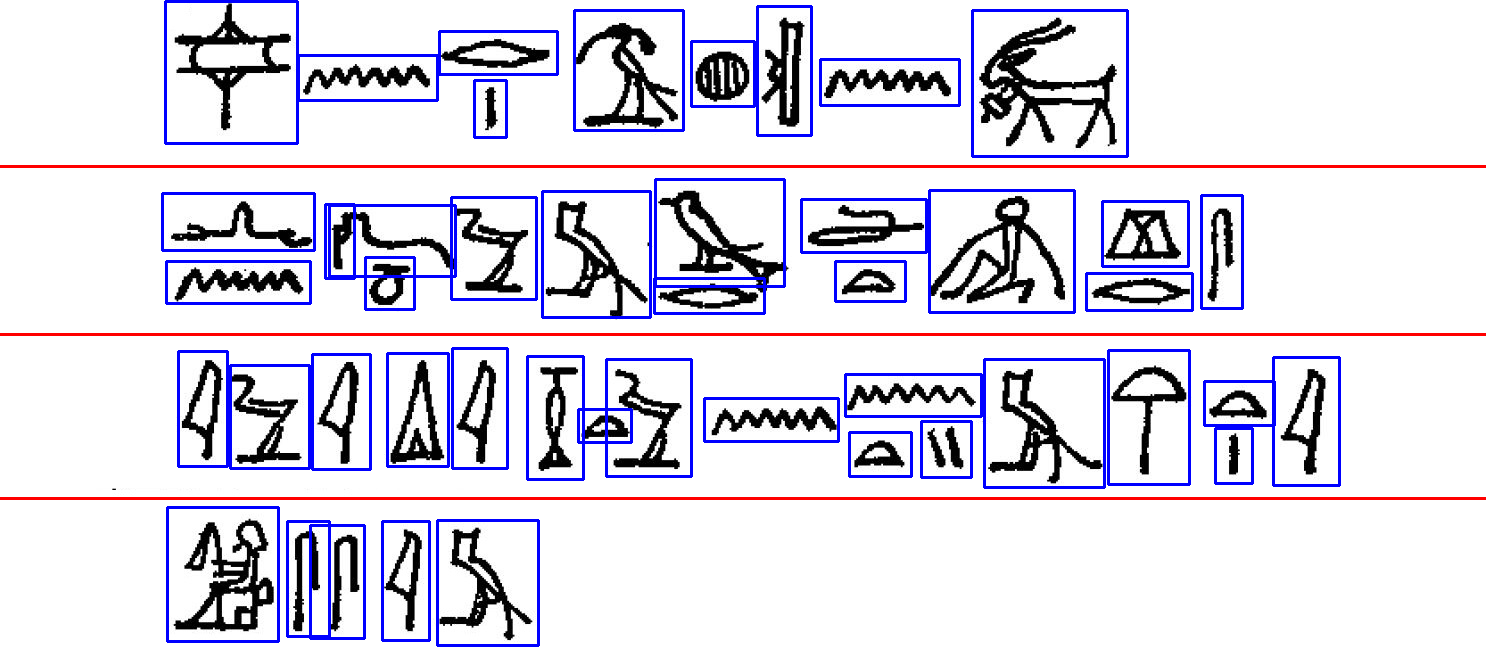


Ausgabe der sortierten Teillisten: 
Teilliste 1


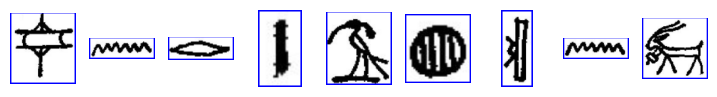

Teilliste 2


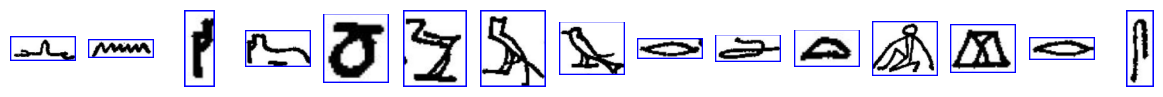

Teilliste 3


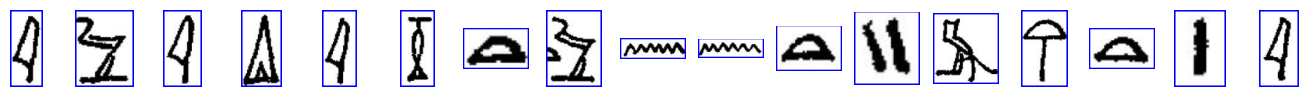

Teilliste 4


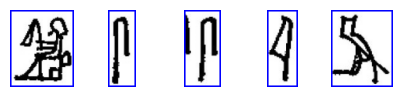


Gardinersequenz: 
P5 I14 D21 M13 G25 O48 Y1a N35 E31 D35 N35 Z1 U13 W24 G43 G17 G36 D21 F46a X1 A7 T28 D21 S29 M18 G43 M17 X8 M17 U36 X1 G43 I14 N35 X1 Z4 G17 S36 X1 Z1 M17 A51 S29 S29 M17 G17

Gelabeltes Ergebnisbild: 


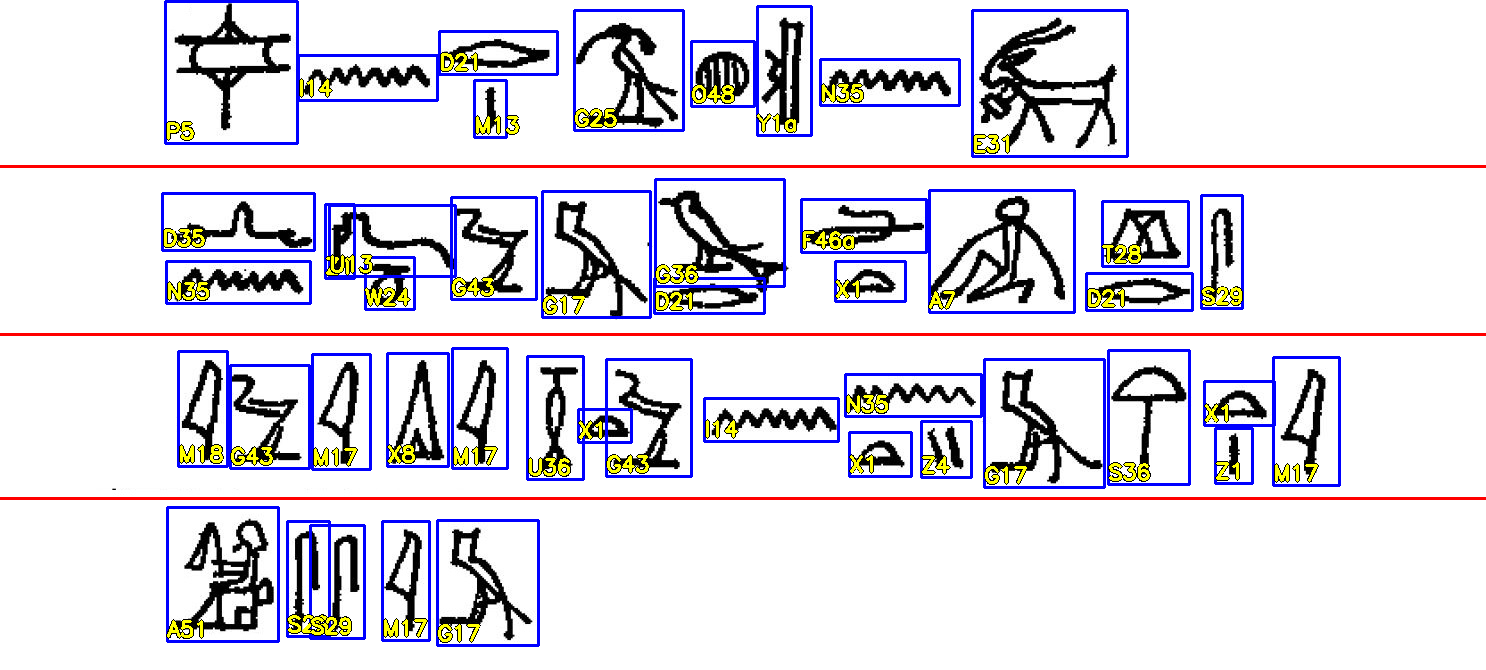

In [86]:
# Lade das Bild mit OpenCV
# Speichere eine Kopie des Originals
img_orig = img_geladen.copy()
img = img_geladen.copy()
print("Originalbild: ")
cv2_imshow(img)

time.sleep(2)  # Warte 2 Sekunden

# Durchführung der Inferenz mit dem YOLO-Modell
print()
results = model.predict(img, verbose=False)

# Extraktion der vorhergesagten Klasse
predicted_class_index = results[0].probs.top1  # Index der wahrscheinlichsten Klasse

# Label der wahrscheinlichsten Klasse
direction = model.names[predicted_class_index]  # Label aus dem model.names-Dictionary

# User fragen, ob der Wert okay ist
user_input = input(f"Ist die Links-Rechts-Leserichtung {direction} korrekt? (Y/N): ")

# Wert ändern, wenn der User N eingibt
if user_input.upper() == "N":
    if direction == "RL":
        direction = "LR"
    else:
        direction = "RL"
print("Links-Rechts-Leserichtung: ", direction)

# Segmentierung mit Detectron
outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
bboxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
bboxes_reduced = []

# Bestimme die längsten Linien, die keine BB schneiden
longest_lines = find_longest_lines(bboxes, img.shape[1], img.shape[0])

# bboxes_reduced auf dem Bild ausgeben
for bbox in bboxes:
    x1, y1, x2, y2 = map(int, bbox)  # Koordinaten in Integer umwandeln
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blaue Bounding Boxes

# Zentriere die Bänder
centered_lines = center_lines(longest_lines)

# Ausrichtung bestimmen
arrangement, x_midpoints, y_midpoints = determine_arrangement(centered_lines, bboxes)
print("Arrangement:", arrangement)
print("x_midpoints:", x_midpoints)
print("y_midpoints:", y_midpoints)

# Linien auf das Bild zeichnen (mit roter Farbe)
for line in centered_lines:
  if arrangement == "Spalten":
    cv2.line(img, line[0], line[1], (0, 0, 255), 1) # Farbe auf Rot gesetzt
    cv2.line(img, (line[0][0] - 1, line[0][1]), (line[1][0] - 1, line[1][1]), (0, 0, 255), 1) # Farbe auf Rot gesetzt
    cv2.line(img, (line[0][0] + 1, line[0][1]), (line[1][0] + 1, line[1][1]), (0, 0, 255), 1) # Farbe auf Rot gesetzt
  else:
    cv2.line(img, line[0], line[1], (0, 0, 255), 1) # Farbe auf Rot gesetzt
    cv2.line(img, (line[0][0], line[0][1] - 1), (line[1][0], line[1][1] - 1), (0, 0, 255), 1) # Farbe auf Rot gesetzt
    cv2.line(img, (line[0][0], line[0][1] + 1), (line[1][0], line[1][1] + 1), (0, 0, 255), 1) # Farbe auf Rot gesetzt

# Bild anzeigen
print()
print("Segmentierung und Trennlinien: ")
cv2_imshow(img)

# Aufteilen der Bounding Boxen in Teilisten
sublists_bboxes = split_bounding_boxes(bboxes, arrangement, direction, x_midpoints, y_midpoints)

# Sortieren der Bounding Boxes und Extrahieren der Bildausschnitte und Bounding Boxes
all_image_crops_and_bboxes = sort_bboxes_and_extract_images(sublists_bboxes, img_orig, arrangement, direction)

# Ausgabe der Sortierung
print()
print("Ausgabe der sortierten Teillisten: ")
display_image_crops_horizontally_matplotlib(all_image_crops_and_bboxes, sublists_bboxes, arrangement, direction, max_edge_length=100)

# Liste zum Speichern der vorhergesagten Klassen
predicted_classes = []

# Klassifizierung der gecroppten Bilder
for image_crop in all_image_crops_and_bboxes:
    # Crop in Graustufen umwandeln
    image_crop_img = cv2.cvtColor(image_crop[0], cv2.COLOR_BGR2GRAY)

    # Inferenz mit dem YOLO-Modell
    results = model2.predict(image_crop_img, verbose=False)
    #cv2_imshow(image_crop)

    # Extraktion der vorhergesagten Klasse
    predicted_class_index = results[0].probs.top1
    predicted_class = model2.names[predicted_class_index]

    # Hinzufügen der vorhergesagten Klasse zur Liste
    predicted_classes.append(predicted_class)

    # Zeichne die Bounding Box und das Label auf dem Bild img (SCHRIFTGRÖSSE UND -DICKE GGF. ANPASSSEN)
    bbox = image_crop[1]
    x1, y1, x2, y2 = bbox.astype(int)
    cv2.putText(img, predicted_class, (x1, y2 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 4)  # Schwarzer Rand
    cv2.putText(img, predicted_class, (x1, y2 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)  # Gelbe Schrift

# Ausgabe der Liste
print()
print("Gardinersequenz: ")
# Entferne alle Zeichen, die keine Buchstaben, Zahlen oder Leerzeichen sind
predicted_classes_cleaned = re.sub(r"[^a-zA-Z0-9 ]", "", " ".join(predicted_classes))
print(predicted_classes_cleaned)

# Zeige das Bild mit den Bounding Boxes und Labels an
print()
print("Gelabeltes Ergebnisbild: ")
cv2_imshow(img)


# Übersetzer von De Cao et al. (optional)

Quelle: https://github.com/mattia-decao/hiero-transformer

Modell laden (ca. 2 GB!)

In [105]:
# Load environment and model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained("mattiadc/hiero-transformer")
#model = AutoModelForSeq2SeqLM.from_pretrained("mattiadc/hiero-transformer").to('cuda:0').eval()  # mit CUDA
model = AutoModelForSeq2SeqLM.from_pretrained("mattiadc/hiero-transformer").to('cpu').eval()  # ohne CUDA

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Funktionen

In [106]:
lang_to_m2m_lang_id = {
    'ea': 'ar',
    'tnt': 'ar',
    'en': 'en',
    'de': 'de',
    'lKey': 'my',
    'tnt': 'lo',
    'wordClass': 'th',
}

langs = [
 ('ea', 'de'),
 ('ea', 'en'),
 ('ea', 'tnt'),
 ('ea', 'lKey'),
 ('ea', 'wordClass'),
 ('tnt', 'de'),
 ('tnt', 'en'),
 ('tnt', 'lKey'),
 ('tnt', 'wordClass'),
]

def get_translation(language_input, language_output, sentence_input):
  with torch.no_grad():
    with torch.cuda.amp.autocast():
      tokenizer.src_lang = lang_to_m2m_lang_id[language_input]
      tokenizer.tgt_lang = lang_to_m2m_lang_id[language_output]

      model_inputs = tokenizer([sentence_input], return_tensors="pt").to(model.device)
      generated_tokens = model.generate(
          **model_inputs,
          num_beams=20,
          max_length=300,
          #min_length=50,
          repetition_penalty=2.0,
          no_repeat_ngram_size=3,
          #length_penalty=1.0,
          early_stopping=True,
          forced_bos_token_id=tokenizer.get_lang_id(lang_to_m2m_lang_id[language_output]))
      return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]


Übersetzung des Outputs von oben

In [107]:
# Parametereinstellung und Einlesen der Ergebnissequenz von oben
language_input = 'ea'
sentence_input = predicted_classes_cleaned
all_outputs = True

if not all_outputs:
  assert (language_input, language_output) in langs, 'Coppia lingue non valida'
  result =  get_translation(language_input, language_output, sentence_input)
else:
  result = {
      language_output: get_translation(language_input, language_output, sentence_input)
      for language_input_tmp, language_output in langs if language_input == language_input_tmp
  }
result

<ipython-input-106-790a25f56a44>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


{'de': 'Die Atemluft ist für die Dämmerung der Ehrwürdigkeit bezüglich der Rechte, die unter ihr ist, und die Totenpriesterphyle, die an der Spitze der beiden Throne sind.',
 'en': 'The smell of the wicked, which was placed in the necropolis.',
 'tnt': 'w r w  n sḥ nn pr,w m wr pẖr,t ẖr =s jy.wj ḥmw,t n,tj m pš =s jm',
 'lKey': '174480 91901 600304 79800 129120 84550 60310 500292 48130 61900 123910 10090 21930 104690 10050 64364 152880 10090 24640',
 'wordClass': 'substantive_masc preposition adjective verb_2-lit preposition personal_pronoun nisbe_adjective_preposition gods_name preposition epith_god preposition verb_3-inf prepositional_adverb verb_irr place_name relative_pr'}